In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
T = 100
K = 3
D = 2
num_particles = 50

NUM_HIDDEN = 256
NUM_LATENTS = K*K
NUM_OBS = T * K
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
CUDA = False

RESTORE = False

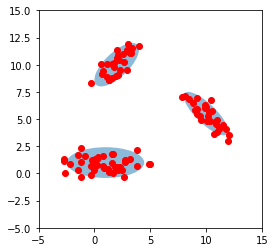

In [3]:
Xs, mus_true, covs_true = sampling_hmm()
plot_samples(Xs, mus_true, covs_true)
Y = torch.from_numpy(Xs).float()

In [4]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, num_particles=1):
        A_samples = torch.zeros((K, num_particles, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden).view(K, K))
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample((num_particles,))
        return latents_dirs, A_samples

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer

alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)
enc, optimizer = initialize()
## initialization
cov_ks = torch.zeros((K, D, D))
mu_ks = torch.zeros((K, D))
for k in range(K):
## sample mu_k and Sigma_k randomly
    cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
    mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
Pi = Dirichlet(alpha_init_0).sample()
A = torch.zeros((K, K)).float()
for k in range(K):
    A[k] = Dirichlet(alpha_trans_0[k]).sample()

In [6]:
def wake_elbo(A_samples, latents_dir, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Zs, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles=1):
    log_p_joint = torch.zeros(num_particles)
    for n in range(num_particles):
        A = A_samples[:, n, :]
        log_p_joint[n] = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Zs, Pi, A, mu_ks, cov_ks, Y, T, D, K).item()
    log_q = torch.zeros((K, num_particles))
    for k in range(K):
        log_q[k] = Dirichlet(latents_dirs[k]).log_prob(A_samples[k])
    log_q = log_q.sum(0)
    log_weights = log_p_joint - log_q - log_sum_exp(log_p_joint - log_q)
    log_weights = log_weights.detach()
    weights = torch.exp(log_weights)
    loss = - torch.mul(weights, log_q).sum()
    return loss

In [11]:
LLs = torch.zeros(NUM_EPOCHS)
for epoch in range(NUM_EPOCHS):
    Zs, log_weights = smc_hmm(Pi, A, mu_ks, cov_ks, Y, T, D, K, num_particles)
    z_argmax = torch.max(log_weights[-1, :], 0)[1].item()
    Zs_max = Zs[:, z_argmax, :]
    N_ks, Y_ks, S_ks = stats(Zs_max, Y, D, K)
    Pi, mu_ks, cov_ks = gibbs_global(Zs_max, alpha_init_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, T, D, K)
    latents_dirs, A_samples = enc(Zs_max.contiguous().view(-1, T*K), num_particles)
    loss = wake_elbo(A_samples, latents_dirs, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Zs_max, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles)
    loss.backward()
    optimizer.step()
    latents_dirs, A_samples = enc(Zs_max.contiguous().view(-1, T*K), num_particles)    
    ## draw a sample for A
    for k in range(K):
        A[k] = Dirichlet(latents_dirs[k]).sample()
    A = A.detach()
    LLs[epoch] = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Zs_max, Pi, A, mu_ks, cov_ks, Y, T, D, K).item()

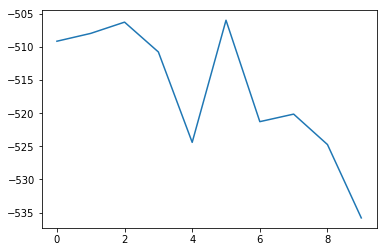

In [12]:
plt.plot(LLs.data.numpy())

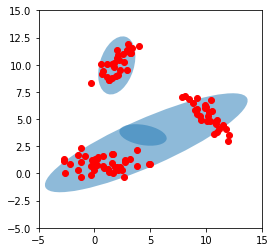

In [13]:
plot_clusters(Xs, mu_ks.data.numpy(), cov_ks.data.numpy())

In [14]:
A

tensor([[0.4752, 0.0015, 0.5233],
        [0.1296, 0.5587, 0.3118],
        [0.6377, 0.0020, 0.3603]])